In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
import sys
print sys.executable

/home/stud/shalaby/.virtualenv/thesis-env/bin/python2


In [3]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [4]:
IS_SAMPLE = False

In [5]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [6]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100 # Suggested by Levy and goldberg
MIN_SIZE = 0
NUM_CORES = 16

In [7]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [9]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new_abs_desc", "full")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

abstracts_map_file = exports_location + "abstracts_tokenized_map.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 16.8 s, sys: 812 ms, total: 17.6 s
Wall time: 17.8 s


In [11]:
%%time
abstracts_map = pickle.load(open(abstracts_map_file))

CPU times: user 4min 37s, sys: 40 s, total: 5min 17s
Wall time: 5min 16s


In [12]:
len(training_docs_list)

1286325

In [13]:
len(validation_docs_list)

321473

In [14]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [15]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [16]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [17]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = set(doc_classification_map[validation_doc_id]) & classifications_set
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels, dtype=np.int8)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = set(doc_classification_map[validation_doc_id]) & classifications_set
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels, dtype=np.int8)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [18]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    training_data = []
    training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
    for i,doc_id in enumerate(training_docs_list):
        normal_array = doc2vec_model.docvecs[doc_id]
        training_data.append(normal_array)
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        if i % 100000 == 0:
            info("Finished {} in training".format(i))
    info("doing matrix creation")
    training_data_mat = np.array(training_data)
    del training_data
    return training_data_mat, training_labels_mat

In [19]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        del self.curr_lines, self.curr_docids
        self.curr_lines, self.curr_docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if abstracts_map.get(doc_id) is not None:
                    abstract_tokens = abstracts_map.get(doc_id)
                    # print "Found Abstract for {}->{}".format(doc_id, len(abstracts_tokens))
                    # time.sleep(0.1)
                    tokens = abstract_tokens + tokens
                    
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

### Doc2vec and SVM Parameters

In [20]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 10000 # report the progress every x terms

In [21]:
SVM_ITERATIONS = 10
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
SVM_CLASS_WEIGHTS = None
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

## Create the Doc2vec model

In [22]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [23]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [24]:
%%time
training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2017-03-02 11:59:42,093 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/vocab_model/model
2017-03-02 11:59:58,950 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/vocab_model/model.docvecs.* with mmap=None
2017-03-02 11:59:58,951 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/vocab_model/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-02 12:00:01,852 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/vocab_model/model.syn1neg.npy with mmap=None
2017-03-02 12:00:02,791 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/vocab_model/model.syn0.npy with mmap=None
2017-03-02 12:00:03,781 : INFO : setting ignored attribute syn0norm to None
2017-03-02 12:00:03,783 : INFO : setting ignored attribute cum_table to None
2017-03

CPU times: user 32.9 s, sys: 6.66 s, total: 39.6 s
Wall time: 41.3 s


In [25]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [26]:
doc2vec_model.alpha = 0.025
doc2vec_model.min_alpha = 0.025
DOC2VEC_ALPHA_DECREASE = 0.001
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'

In [27]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

#### Load from a certain epoch if needed

In [36]:
epoch = 2
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    info("Doc2vec Alpha: {}".format(doc2vec_model.alpha))
    info("Loaded the Doc2vec Model")

2017-01-21 03:30:07,077 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-01-21 03:30:07,079 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model
2017-01-21 03:30:16,169 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.* with mmap=None
2017-01-21 03:30:16,171 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-21 03:30:21,629 : INFO : loading syn1neg from /mnt/dat

<IPython.core.display.Javascript object>


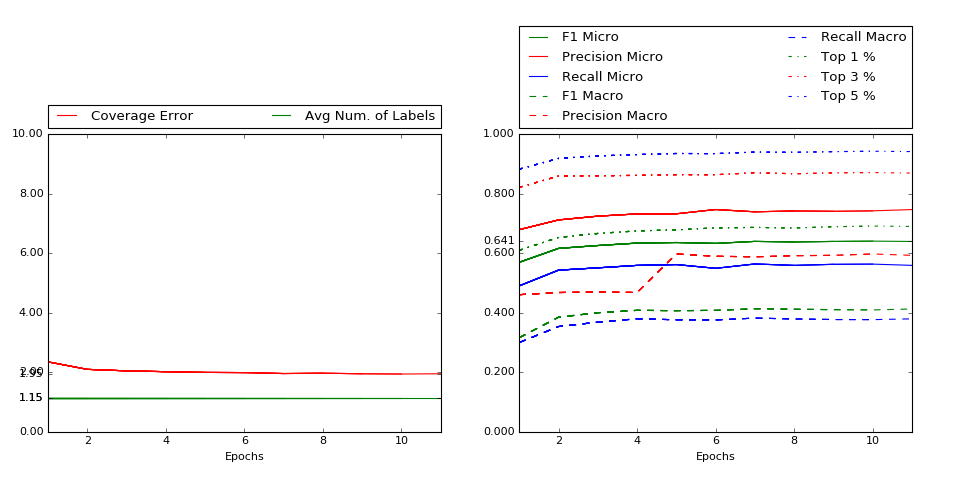

2017-03-02 12:23:32,751 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-03-02 12:23:32,753 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-03-02 12:23:46,572 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-03-02 12:23:46,574 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-02 12:23:50,364 : INFO : loading syn1neg from /mnt/

[[1 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]]


2017-03-02 12:24:47,821 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-03-02 12:24:47,823 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model


** Validation Metrics: Cov Err: 2.356, Avg Labels: 1.150, 
		 Top 1: 0.611, Top 3: 0.822, Top 5: 0.883, 
		 F1 Micro: 0.570, F1 Macro: 0.317, Total Pos: 266,713


2017-03-02 12:25:03,017 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.* with mmap=None
2017-03-02 12:25:03,018 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-02 12:25:07,341 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.syn1neg.npy with mmap=None
2017-03-02 12:25:08,721 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.syn0.npy

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2017-03-02 12:25:51,996 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-03-02 12:25:51,997 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model


** Validation Metrics: Cov Err: 2.105, Avg Labels: 1.150, 
		 Top 1: 0.654, Top 3: 0.860, Top 5: 0.919, 
		 F1 Micro: 0.617, F1 Macro: 0.386, Total Pos: 281,814


2017-03-02 12:26:06,519 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.* with mmap=None
2017-03-02 12:26:06,519 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-02 12:26:09,363 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.syn1neg.npy with mmap=None
2017-03-02 12:26:10,719 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.syn0.npy

[[0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2017-03-02 12:27:07,716 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-03-02 12:27:07,717 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model


** Validation Metrics: Cov Err: 2.055, Avg Labels: 1.150, 
		 Top 1: 0.667, Top 3: 0.861, Top 5: 0.928, 
		 F1 Micro: 0.627, F1 Macro: 0.401, Total Pos: 280,807


2017-03-02 12:27:23,093 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.docvecs.* with mmap=None
2017-03-02 12:27:23,093 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-02 12:27:27,393 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.syn1neg.npy with mmap=None
2017-03-02 12:27:28,774 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.syn0.npy

[[0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2017-03-02 12:28:11,284 : INFO : ****************** Epoch 5 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5 *******************
2017-03-02 12:28:11,286 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model


** Validation Metrics: Cov Err: 2.027, Avg Labels: 1.150, 
		 Top 1: 0.676, Top 3: 0.862, Top 5: 0.932, 
		 F1 Micro: 0.635, F1 Macro: 0.409, Total Pos: 282,083


2017-03-02 12:28:26,643 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.docvecs.* with mmap=None
2017-03-02 12:28:26,645 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-02 12:28:29,578 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.syn1neg.npy with mmap=None
2017-03-02 12:28:30,959 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.syn0.npy

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]]


2017-03-02 12:29:28,282 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-03-02 12:29:28,283 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model


** Validation Metrics: Cov Err: 2.002, Avg Labels: 1.150, 
		 Top 1: 0.679, Top 3: 0.865, Top 5: 0.936, 
		 F1 Micro: 0.637, F1 Macro: 0.408, Total Pos: 283,317


2017-03-02 12:29:32,763 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.* with mmap=None
2017-03-02 12:29:32,765 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-02 12:29:35,990 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn1neg.npy with mmap=None
2017-03-02 12:29:37,406 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abs_desc/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn0.npy

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]]


2017-03-02 18:51:24,443 : INFO : ****************** Epoch 8 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8 *******************
2017-03-02 18:51:24,444 : INFO : training model with 16 workers on 393600 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=10
2017-03-02 18:51:24,444 : INFO : expecting 1657345 sentences, matching count from corpus used for vocabulary survey
2017-03-02 18:51:24,448 : INFO : Loading new batch for index: 0


** Validation Metrics: Cov Err: 1.964, Avg Labels: 1.150, 
		 Top 1: 0.687, Top 3: 0.871, Top 5: 0.941, 
		 F1 Micro: 0.640, F1 Macro: 0.414, Total Pos: 281,765


2017-03-02 18:51:31,637 : INFO : Finished loading new batch
2017-03-02 18:51:33,000 : INFO : PROGRESS: at 0.00% examples, 412 words/s, in_qsize 16, out_qsize 1
2017-03-02 18:51:53,011 : INFO : PROGRESS: at 0.30% examples, 755668 words/s, in_qsize 31, out_qsize 3
2017-03-02 18:52:13,038 : INFO : PROGRESS: at 0.62% examples, 884232 words/s, in_qsize 31, out_qsize 0
2017-03-02 18:52:26,021 : INFO : Loading new batch for index: 10000
2017-03-02 18:52:34,029 : INFO : Finished loading new batch
2017-03-02 18:52:34,083 : INFO : PROGRESS: at 0.78% examples, 788109 words/s, in_qsize 8, out_qsize 0
2017-03-02 18:52:54,089 : INFO : PROGRESS: at 1.09% examples, 842974 words/s, in_qsize 32, out_qsize 2
2017-03-02 18:53:14,095 : INFO : PROGRESS: at 1.39% examples, 884415 words/s, in_qsize 31, out_qsize 0
2017-03-02 18:53:27,750 : INFO : Loading new batch for index: 20000
2017-03-02 18:53:35,458 : INFO : Finished loading new batch
2017-03-02 18:53:35,632 : INFO : PROGRESS: at 1.56% examples, 832051 w

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 1.956, Avg Labels: 1.150, 
		 Top 1: 0.690, Top 3: 0.871, Top 5: 0.942, 
		 F1 Micro: 0.640, F1 Macro: 0.411, Total Pos: 280,539


2017-03-03 03:47:09,126 : INFO : ****************** Epoch 10 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10 *******************
2017-03-03 03:47:09,149 : INFO : training model with 16 workers on 393600 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=10
2017-03-03 03:47:09,150 : INFO : expecting 1657345 sentences, matching count from corpus used for vocabulary survey
2017-03-03 03:47:09,155 : INFO : Loading new batch for index: 0
2017-03-03 03:47:17,707 : INFO : Finished loading new batch
2017-03-03 03:47:17,953 : INFO : PROGRESS: at 0.00% examples, 463 words/s, in_qsize 0, out_qsize 0
2017-03-03 03:47:37,972 : INFO : PROGRESS: at 0.28% examples, 712062 words/s, in_qsize 31, out_qsize 1
2017-03-03 03:47:57,959 : INFO : PROGRESS: at 0.58% examples, 826580 words/s, in_qsize 30, out_qsize 1
2017-03-03 03:48:14,748 : INFO : Loading new batch for index: 10000
2017-03-03 03:48:23,046 : INFO : Finished loading new

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 1.948, Avg Labels: 1.150, 
		 Top 1: 0.692, Top 3: 0.872, Top 5: 0.943, 
		 F1 Micro: 0.641, F1 Macro: 0.410, Total Pos: 280,293


2017-03-03 08:09:07,829 : INFO : ****************** Epoch 11 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11 *******************
2017-03-03 08:09:07,830 : INFO : training model with 16 workers on 393600 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=10
2017-03-03 08:09:07,830 : INFO : expecting 1657345 sentences, matching count from corpus used for vocabulary survey
2017-03-03 08:09:07,835 : INFO : Loading new batch for index: 0
2017-03-03 08:09:15,920 : INFO : Finished loading new batch
2017-03-03 08:09:17,062 : INFO : PROGRESS: at 0.00% examples, 382 words/s, in_qsize 0, out_qsize 3
2017-03-03 08:09:37,051 : INFO : PROGRESS: at 0.30% examples, 749511 words/s, in_qsize 31, out_qsize 0
2017-03-03 08:09:57,058 : INFO : PROGRESS: at 0.62% examples, 882710 words/s, in_qsize 31, out_qsize 0
2017-03-03 08:10:09,778 : INFO : Loading new batch for index: 10000
2017-03-03 08:10:16,787 : INFO : Finished loading new

[[0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 1.957, Avg Labels: 1.150, 
		 Top 1: 0.691, Top 3: 0.870, Top 5: 0.942, 
		 F1 Micro: 0.640, F1 Macro: 0.413, Total Pos: 276,617


2017-03-03 12:33:54,313 : INFO : ****************** Epoch 12 --- Working on doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12 *******************
2017-03-03 12:33:54,314 : INFO : training model with 16 workers on 393600 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=10
2017-03-03 12:33:54,316 : INFO : expecting 1657345 sentences, matching count from corpus used for vocabulary survey
2017-03-03 12:33:54,365 : INFO : Loading new batch for index: 0
2017-03-03 12:34:02,713 : INFO : Finished loading new batch
2017-03-03 12:34:03,156 : INFO : PROGRESS: at 0.00% examples, 468 words/s, in_qsize 4, out_qsize 0
2017-03-03 12:34:23,172 : INFO : PROGRESS: at 0.30% examples, 754913 words/s, in_qsize 25, out_qsize 5
2017-03-03 12:34:43,167 : INFO : PROGRESS: at 0.57% examples, 808958 words/s, in_qsize 31, out_qsize 0
2017-03-03 12:35:00,703 : INFO : Loading new batch for index: 10000
2017-03-03 12:35:08,377 : INFO : Finished loading new

KeyboardInterrupt: 

In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        info("Doc2vec Alpha: {}".format(doc2vec_model.alpha))
        info("Loaded the Doc2vec Model")
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= DOC2VEC_ALPHA_DECREASE  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
        word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
        epoch_word2vec_metrics.append(word2vec_result)
        pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                                       WORD2VEC_METRICS_FILENAME), 'w'))


    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER)):

        info('Getting training Data')
        X, y = get_training_data(doc2vec_model, classifications)
        
        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


        # Training of a classifier
        clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'w'))
        
    #     # Training Metrics
    #     info('Evaluating on Training Data')
    #     yp = clf.predict(X)
    #     yp_score = clf.decision_function(X)
    #     print yp
    #     training_metrics = get_metrics(y, yp_score, yp)
    #     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    #         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
    #         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
    #         training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])

    #     epoch_training_metrics.append(training_metrics)
          # Saving the metrics
    #     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
    #                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))

        del X, y

    else:
        info('Loading Classifier')
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'r'))
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    yvp_score = clf.decision_function(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp_score, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))



In [34]:
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

# get the word2vec analogy accuracy score
word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
epoch_word2vec_metrics.append(word2vec_result)
pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                               WORD2VEC_METRICS_FILENAME), 'w'))


2017-01-21 01:39:32,179 : INFO : saving Doc2Vec object under /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model, separately None
2017-01-21 01:39:32,182 : INFO : storing numpy array 'syn1neg' to /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.syn1neg.npy
2017-01-21 01:39:36,042 : INFO : not storing attribute syn0norm
2017-01-21 01:39:36,045 : INFO : storing numpy array 'syn0' to /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.syn0.npy
2017-01-21 01:39:37,125 : INFO : not storing attribute cum_table
2017-01-21 01:39:55,860 : INFO : precomputing L2-norms of word weight vectors
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-pac

In [37]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(7)

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))


2017-01-07 08:29:42,629 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model
2017-01-07 08:29:56,527 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.docvecs.* with mmap=None
2017-01-07 08:29:56,529 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.syn1neg.npy with mmap=None
2017-01-07 08:30:01,849 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.syn0.npy with mmap=None
2017-01-07 08:30:02,162 : INFO : setting ignored attribu

In [51]:
%%time
ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

# get the word2vec analogy accuracy score
%time word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
epoch_word2vec_metrics.append(word2vec_result)
pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                               WORD2VEC_METRICS_FILENAME), 'w'))


2017-01-09 08:57:31,563 : INFO : saving Doc2Vec object under /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model, separately None
2017-01-09 08:57:31,565 : INFO : storing numpy array 'syn1neg' to /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.syn1neg.npy
2017-01-09 08:57:43,811 : INFO : not storing attribute syn0norm
2017-01-09 08:57:43,813 : INFO : storing numpy array 'syn0' to /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.syn0.npy
2017-01-09 08:57:44,083 : INFO : not storing attribute cum_table
2017-01-09 08:58:16,480 : INFO : precomputing L2-norms of word weight vectors
2017-01-09 08:58:34,486 : INFO : capital-common-countries: 0.3% (1/306)
2017-01-09 08:58

CPU times: user 44min 10s, sys: 2h 7min 46s, total: 2h 51min 56s
Wall time: 10min 47s
CPU times: user 44min 28s, sys: 2h 7min 55s, total: 2h 52min 23s
Wall time: 11min 31s
